In [21]:
import torch
import torchphysics as tp
import math

In [22]:
X = tp.spaces.R2('x')
P = tp.spaces.R1('p')
U = tp.spaces.R2('u')
A = tp.spaces.R1("alpha")

In [23]:
h, w = 1, 1
mu = 0.5
scale = 4.0


Omega = tp.domains.Parallelogram(X, [0, 0], [w, 0], [0, h])
A_int = tp.domains.Interval(A, 0, math.pi/3.0)

In [24]:
inner_sampler = tp.samplers.RandomUniformSampler(Omega*A_int, 80000)

tol = 0.0001
def right_boundary(x):
    return x[:, :1] > w - tol

def other_boundary(x):
    return torch.logical_not(right_boundary(x))

dirichlet_boundary_sampler = tp.samplers.RandomUniformSampler(A_int*Omega.boundary, 40000, filter_fn=other_boundary)
#outflow_boundary_sampler = tp.samplers.GridSampler(Omega.boundary, 10000, filter_fn=right_boundary).make_static()

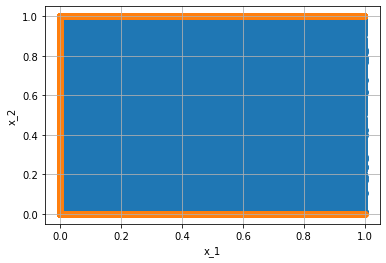

In [25]:
fig = tp.utils.scatter(X, inner_sampler, dirichlet_boundary_sampler)

In [26]:
def inflow_fn(x, alpha):
    inflow_fn = torch.ones_like(x)
    inflow_fn *= scale * x[:, 1:] * (h - x[:, 1:])
    inflow_fn[:, :1] *= torch.cos(alpha) 
    inflow_fn[:, 1:] *= torch.sin(alpha) 
    return inflow_fn

model = tp.models.FCN(input_space=X*A, output_space=U*P, hidden=(60, 60, 50, 50))

In [27]:
def mass_residual(u, x):
    return tp.utils.div(u, x)

mass_condition = tp.conditions.PINNCondition(module=model,
                                            sampler=inner_sampler,
                                            residual_fn=mass_residual, weight=20.0)

In [28]:
def momentum_residual(u, p, x):
    sym_grad = tp.utils.sym_grad(u, x)
    p_grad = tp.utils.grad(p, x)
    return - mu * tp.utils.matrix_div(sym_grad, x) + p_grad

momentum_condition = tp.conditions.PINNCondition(module=model,
                                            sampler=inner_sampler,
                                            residual_fn=momentum_residual)

In [29]:
def dirichlet_residual(u, x, alpha):
    inflow = inflow_fn(x, alpha)
    return u - inflow

dirichlet_condition = tp.conditions.PINNCondition(module=model,
                                            sampler=dirichlet_boundary_sampler,
                                             residual_fn=dirichlet_residual, weight=50.0)

In [30]:
# def outflow_residual(u, p, x):
#     #n = Omega.boundary.normal(x)
#     sym_grad = tp.utils.sym_grad(u, x)
#     res = torch.zeros_like(x)
#     res[:, :1] =  - mu * sym_grad[:, :1, 0] + p
#     res[:, 1:] =  - mu * sym_grad[:, 1:, 0]
#     return res

# outflow_condition = tp.conditions.PINNCondition(module=model,
#                                             sampler=outflow_boundary_sampler,
#                                             residual_fn=outflow_residual)

In [31]:
# def pressure_residual(p):
#     return torch.mean(p, dim=0, keepdim=True)

# pressure_condition = tp.conditions.PINNCondition(model, inner_sampler, pressure_residual)

In [32]:
optim = tp.OptimizerSetting(torch.optim.Adam, lr=1e-3)
solver = tp.solver.Solver([dirichlet_condition, mass_condition, momentum_condition],
                           optimizer_setting=optim)

import pytorch_lightning as pl
trainer = pl.Trainer(gpus=1,
                     num_sanity_val_steps=0,
                     benchmark=True,
                     max_steps=1000, 
                     logger=False, 
                     checkpoint_callback=False)
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 9.7 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
9.7 K     Trainable params
0         Non-trainable params
9.7 K     Total params
0.039     Total estimated model params size (MB)


/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [33]:
mass_condition.sampler = mass_condition.sampler.make_static()
momentum_condition.sampler = momentum_condition.sampler.make_static()
dirichlet_condition.sampler = dirichlet_condition.sampler.make_static()

optim = tp.OptimizerSetting(torch.optim.LBFGS, lr=0.1, optimizer_args={"max_iter" : 5})
solver = tp.solver.Solver([dirichlet_condition, mass_condition, momentum_condition],
                           optimizer_setting=optim)

trainer = pl.Trainer(gpus=1,
                     num_sanity_val_steps=0,
                     benchmark=True,
                     max_steps=400, 
                     logger=False, 
                     checkpoint_callback=False)
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 9.7 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
9.7 K     Trainable params
0         Non-trainable params
9.7 K     Total params
0.039     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

<Figure size 576x576 with 0 Axes>

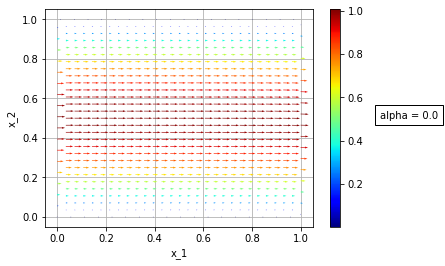

In [39]:
alpha_eval = 0.0

Omega_plot = tp.domains.Parallelogram(X, [0, 0], [1, 0], [0, 1])
plot_sampler = tp.samplers.PlotSampler(Omega_plot, 800, data_for_other_variables={"alpha": alpha_eval})

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
fig = tp.utils.plot(model, lambda u: u, plot_sampler)

<Figure size 576x576 with 0 Axes>

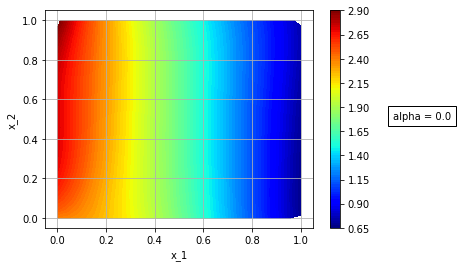

In [40]:
Omega_plot = tp.domains.Parallelogram(X, [0, 0], [1, 0], [0, 1])
plot_sampler = tp.samplers.PlotSampler(Omega_plot, 800, data_for_other_variables={"alpha": alpha_eval})

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
fig = tp.utils.plot(model, lambda p: p, plot_sampler, plot_type="contour_surface")